### Import libraries and read in file

In [28]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('fivethirtyeight')

In [29]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [30]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

In [105]:
df['main_house_total'].head(30);

### X Vars

In [32]:
# time-based features
df['dow'] = df.index.weekday
df['weekday'] = (df.index.weekday < 5)*1
df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
df['hour'] = df.index.hour

# season dummies
df['winter'] = (df.index.month<=3)*1
df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
df['fall'] = (df.index.month>9)*1

In [33]:
# main house power percentage change 1 min intervals
df['pos_mht_pct'] = df['main_house_total'].pct_change(freq='1Min').fillna(0)
df['neg_mht_pct'] = df['main_house_total'].pct_change(freq='-1Min').fillna(0)

In [34]:
# main house power difference 1 min intervals
df['pos_mht_diff'] = df['main_house_total'].diff(periods=1).fillna(0)
df['neg_mht_diff'] = df['main_house_total'].diff(periods=-1).fillna(0)
df['neg_mht_pct'].replace(np.inf,100,inplace=True)
df['pos_mht_pct'].replace(np.inf,100,inplace=True)

In [81]:
# rolling sum and mean
# seems like this might be predictive, how to choose time range? 
time_val = 60
df['rolling_sum'] = df['main_house_total'].rolling(time_val).sum().fillna(0)
df['rolling_mean'] = df['main_house_total'].rolling(time_val).mean().fillna(0)
df['rolling_max']  = df['main_house_total'].rolling(time_val).max().fillna(0)
df['rolling_min']  = df['main_house_total'].rolling(time_val).min().fillna(0)
df['rolling_median']  = df['main_house_total'].rolling(time_val).median().fillna(0)

In [36]:
# build model that classifies when lights or similar turn on
# feed results of that model into ultimate model as feature


In [ ]:
# somehow use arima??


In [73]:
feature_cols = ['dow','hour','winter','spring','summer','pos_mht_pct','Temp (C)',
                'neg_mht_pct','pos_mht_diff','neg_mht_diff','main_house_total',
               'rolling_sum','rolling_mean','rolling_max','rolling_min','rolling_median'
               ]

### ON/OFF Appliance Startups
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [38]:
of_apps = ['dishwasher', 'oven', 'dryer', 'washer']

In [39]:
# identify point when appliance starts up
# appliance must be using more than threshold power 
# and previous points must sum to a small number
for lbl in of_apps:
    # dishwashers seem to obey different rules than the other appliances
    if lbl == 'dishwasher':
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.50)
    else:
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.25)
    roll = df[lbl].rolling(20).sum().shift(1) # rolling sum shifted back 1 minute
    crit = (df[lbl] > lower_thresh)&(df[lbl] > roll) # criteria for appliance startup
    df[lbl+'_start'] = crit*1 # create binary column indicating appliance startup

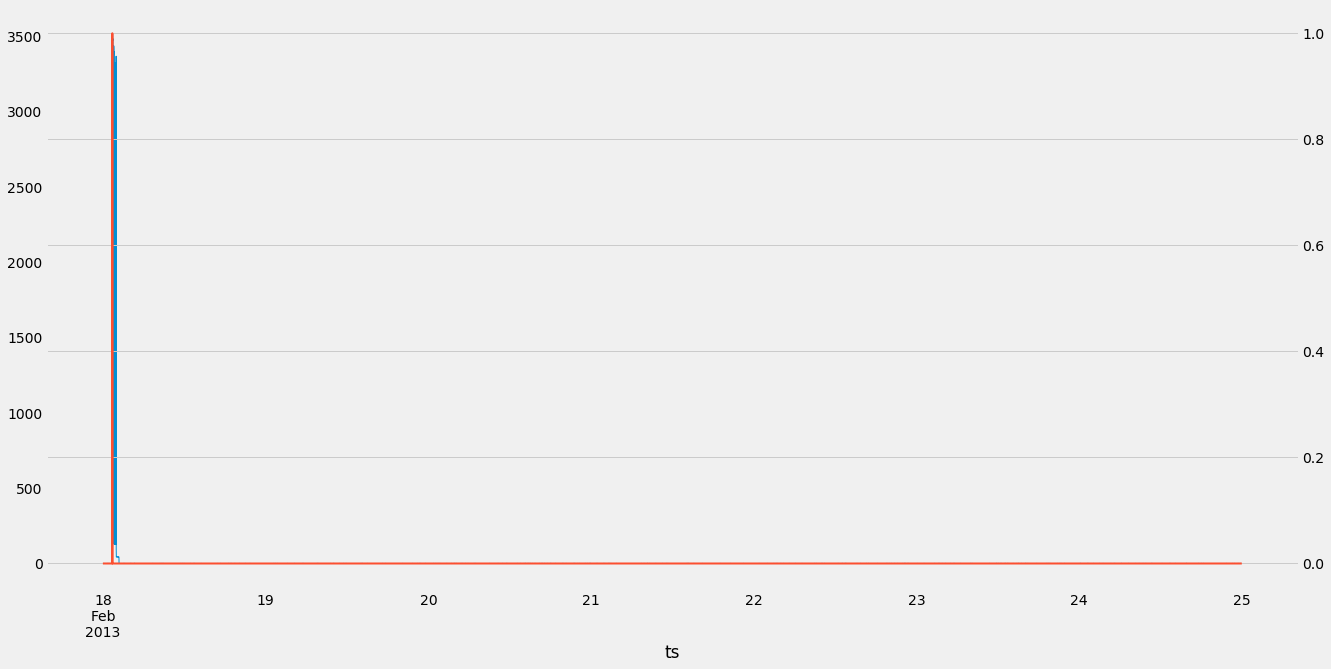

In [40]:
# plot spot checks to see if methodology works
lbl = 'oven'
mask = (df.index.week==8)&(df.index.year==2013)# &(df.index.day==6) #&(df.index.hour > 14)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_start'][mask].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [43]:
# loop through the calculted "start" columns
# find the "1s" and create a countdown starting at 60 mins from that point
# add column to dataframe
for lbl in of_apps:
    res = []
    for val in df[lbl+'_start']:
        if val == 1:
            res.append(60)
        elif not res:
            res.append(0)
        elif val == 0 and res[-1] != 0:
            res.append(res[-1]-1)
        else:
            res.append(0)

    res_shift = res[60:]
    res_shift.extend([0]*60)

    df[lbl+'_countdown'] = res_shift


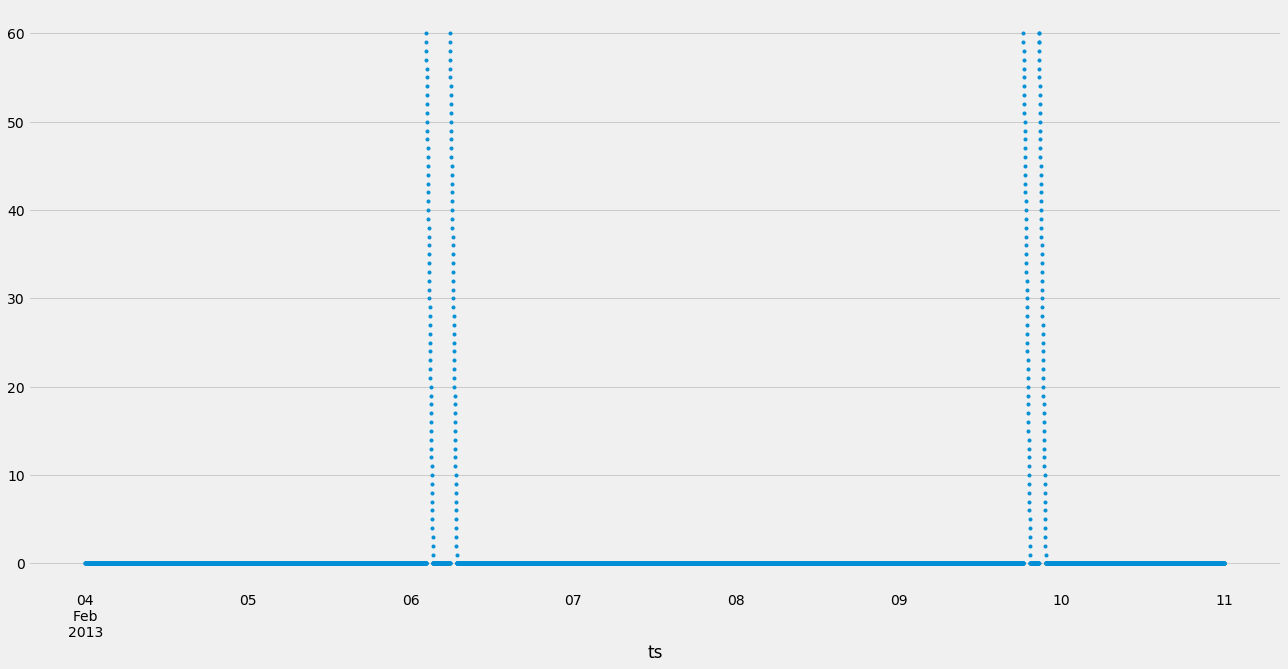

In [44]:
# plot spot checks to see if methodology works
lbl = 'dishwasher'
mask = (df.index.week==6)&(df.index.year==2013)# &(df.index.day==26)&(df.index.hour > 14)
df[lbl+'_countdown'][mask].plot(linewidth=1,figsize=(20,10),style='.');

### Attempt a basic model

In [97]:
# define X and y
X = df[feature_cols]
y = df['washer_countdown']

In [92]:
# instead of just predicting a single appliance, is there a way to predict them as a group? 
# like "I want to predict any of the ON/OFF appliances will turn on in 60 mins"


In [98]:
# TRAIN TEST SPLIT 

# https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
# tscv = TimeSeriesSplit(n_splits=3)
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

train_size = int(len(X) * 0.66)
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [99]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
list(zip(feature_cols, linreg.coef_))

RMSE: 5.389532646042351


[('dow', 0.06679920694904476),
 ('hour', 0.05795386178887018),
 ('winter', 0.08087688880269113),
 ('spring', 0.1510082021094629),
 ('summer', 0.14883481281423638),
 ('pos_mht_pct', 0.07470801852806155),
 ('neg_mht_pct', 0.10316601814323323),
 ('pos_mht_diff', -4.873165575188659e-05),
 ('neg_mht_diff', -0.0001590951853022854),
 ('main_house_total', 5.325047630097557e-05),
 ('rolling_sum', -9.92065535614095e-06),
 ('rolling_mean', -1.6534418765027335e-07),
 ('rolling_max', 0.00027849371996099825),
 ('rolling_min', 0.000219475430527305),
 ('rolling_median', 0.00019204573700966343)]

In [100]:
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
list(zip(feature_cols, ridgereg.coef_))

RMSE: 5.389266748723253


[('dow', 0.060508925047325225),
 ('hour', 0.05268443470623748),
 ('winter', 0.05637101341480131),
 ('spring', 0.11383135220404023),
 ('summer', 0.11336715046538436),
 ('pos_mht_pct', 0.07591266377436366),
 ('neg_mht_pct', 0.08239014665586479),
 ('pos_mht_diff', -3.7333494468252744e-05),
 ('neg_mht_diff', -0.0001338276944364057),
 ('main_house_total', 5.8309841106094306e-05),
 ('rolling_sum', -1.540494859550131e-06),
 ('rolling_mean', -9.24296915730131e-05),
 ('rolling_max', 0.00016441215168414488),
 ('rolling_min', 3.566197971174751e-05),
 ('rolling_median', 2.709538363688137e-05)]

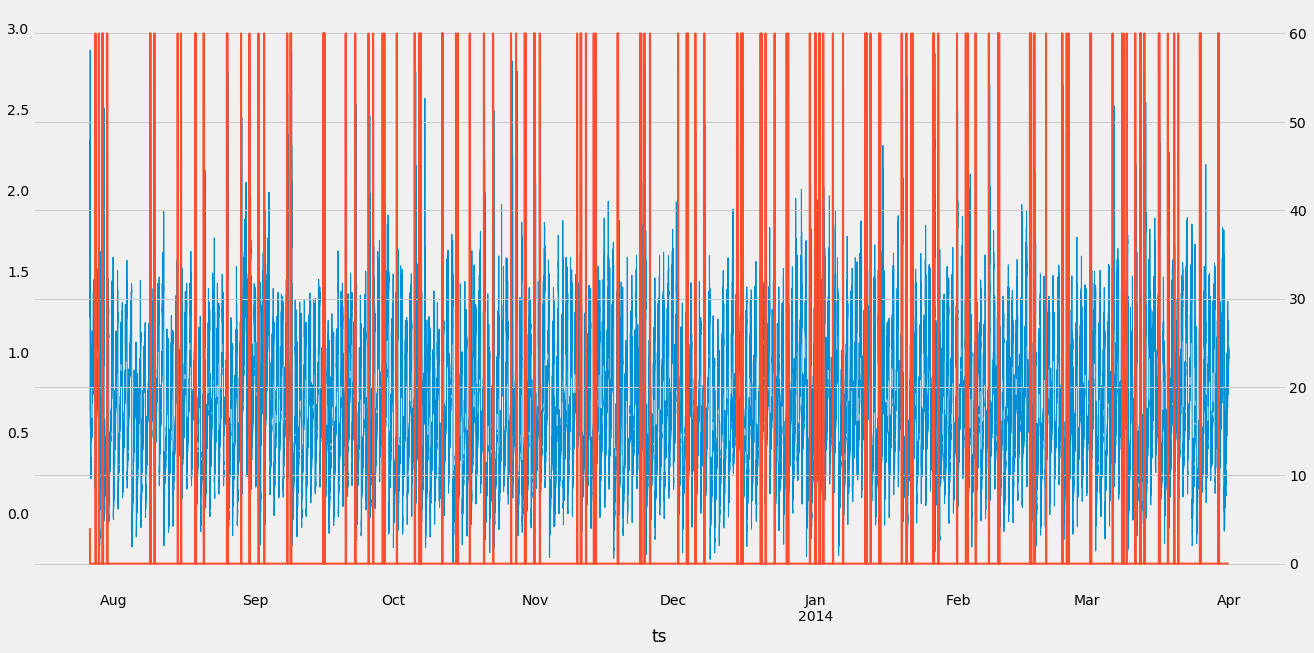

In [102]:
a = pd.DataFrame(data = {'yt':y_test, 'yp':y_pred}, columns=['yt','yp'])
# mask = 
a['yp'].plot(linewidth=1,figsize=(20,10));
a['yt'].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [88]:
lasso = Lasso(alpha=0.00001, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
list(zip(feature_cols, lasso.coef_))

RMSE: 5.4923957449032486


[('dow', 0.05376062589591669),
 ('hour', 0.02225629193159921),
 ('winter', 0.0),
 ('spring', 0.21490217200808093),
 ('summer', -0.02410228351399695),
 ('pos_mht_pct', 0.014353006872338139),
 ('neg_mht_pct', 0.0),
 ('pos_mht_diff', 0.0),
 ('neg_mht_diff', -7.307604495001028e-06),
 ('main_house_total', -5.6443280499956604e-05),
 ('rolling_sum', 0.0),
 ('rolling_mean', 0.0),
 ('rolling_max', 0.00027896231043721234),
 ('rolling_min', 0.0008698093646560518),
 ('rolling_median', 0.00015904933296112547)]

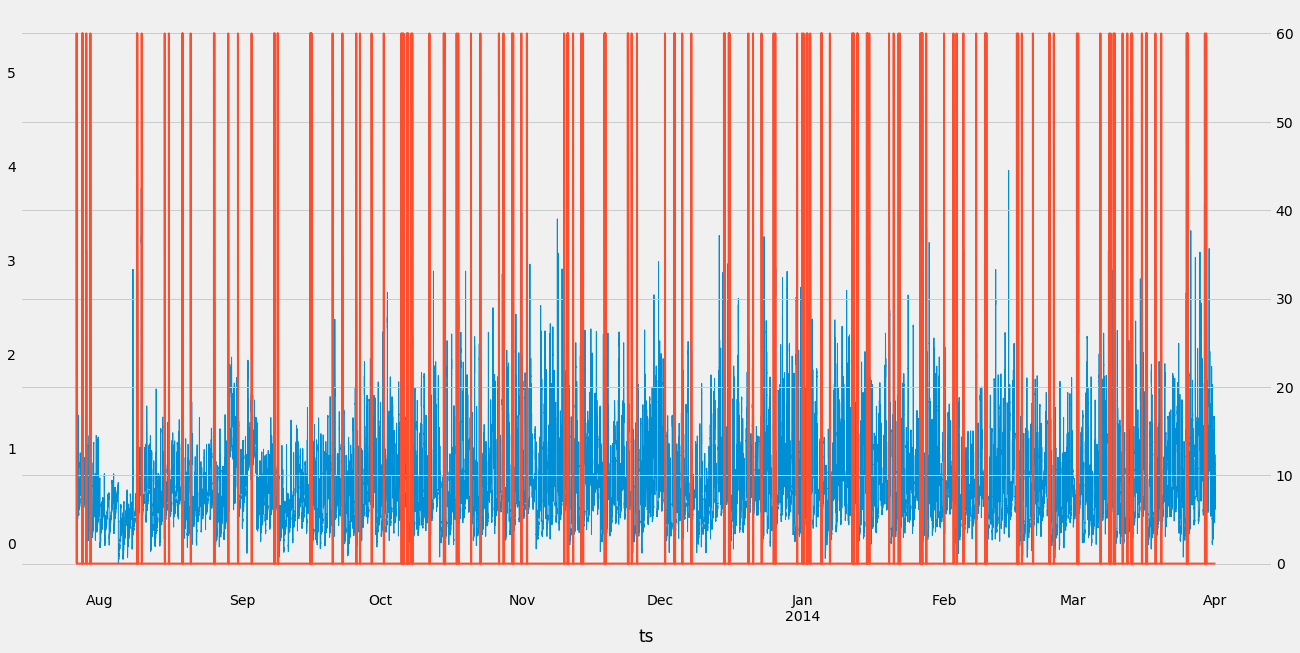

In [89]:
a = pd.DataFrame(data = {'yt':y_test, 'yp':y_pred}, columns=['yt','yp'])
a['yp'].plot(linewidth=1,figsize=(20,10));
a['yt'].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [58]:
treereg = DecisionTreeRegressor()
treereg.fit(X_train,y_train)
y_pred = treereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 7.818433239668317
